In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0 , 0.3 , 0.55/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

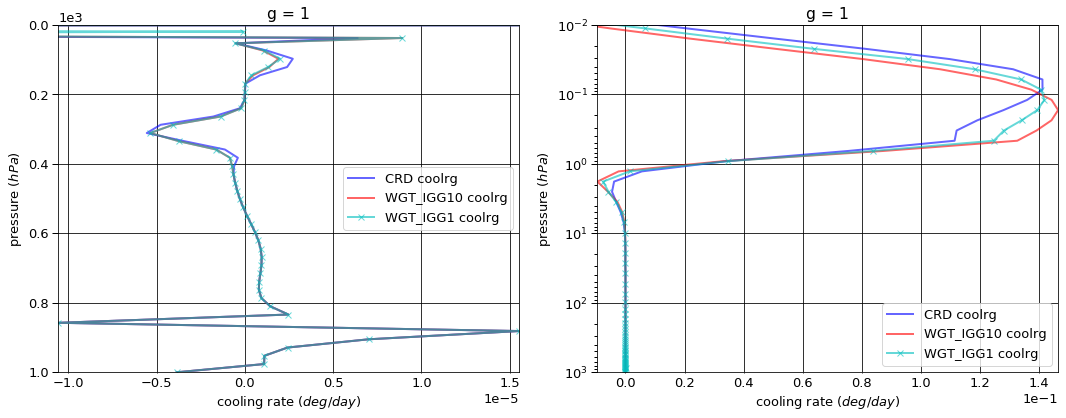

# Figure: cooling rate g-group 2

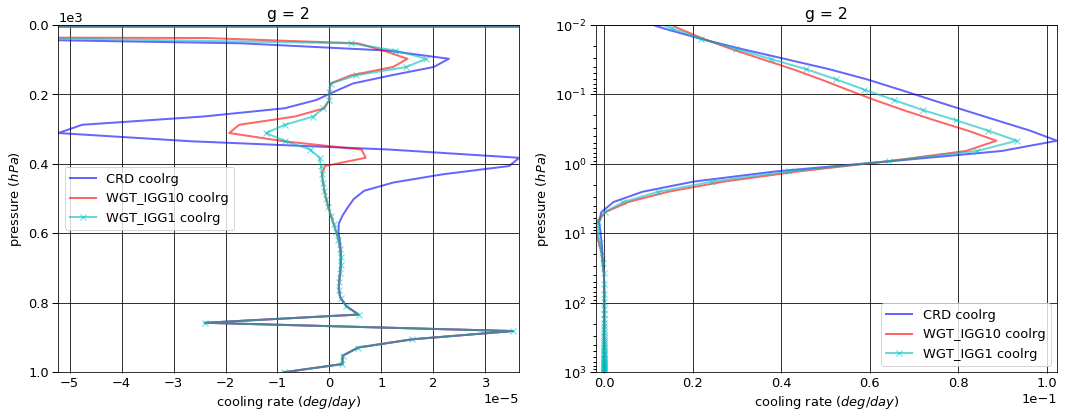

# Figure: cooling rate g-group 3

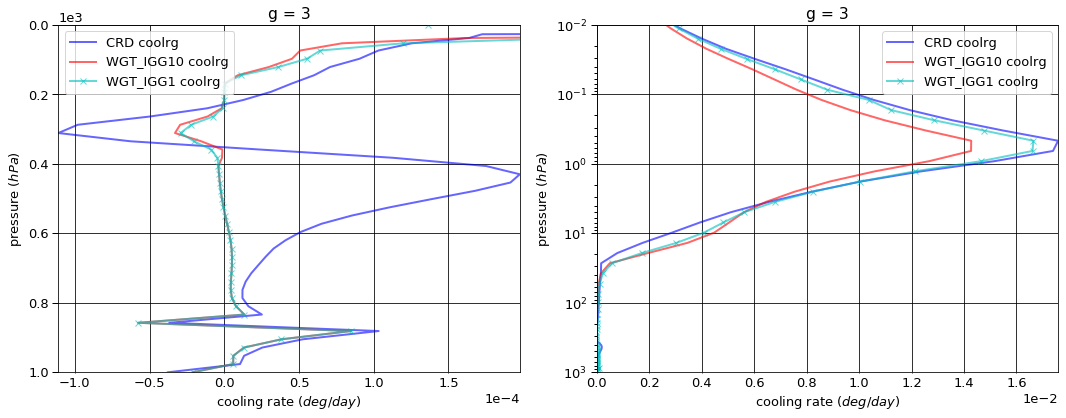

# Figure: cooling rate g-group 4

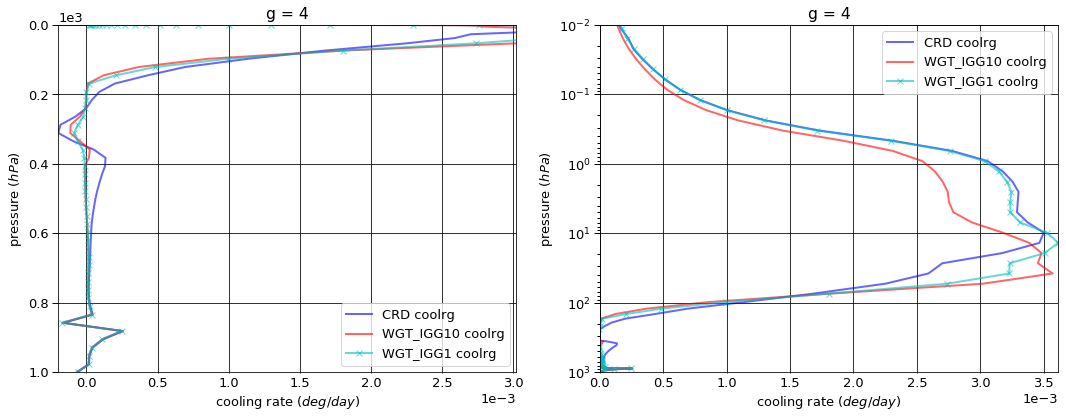

# Figure: cooling rate g-group 5

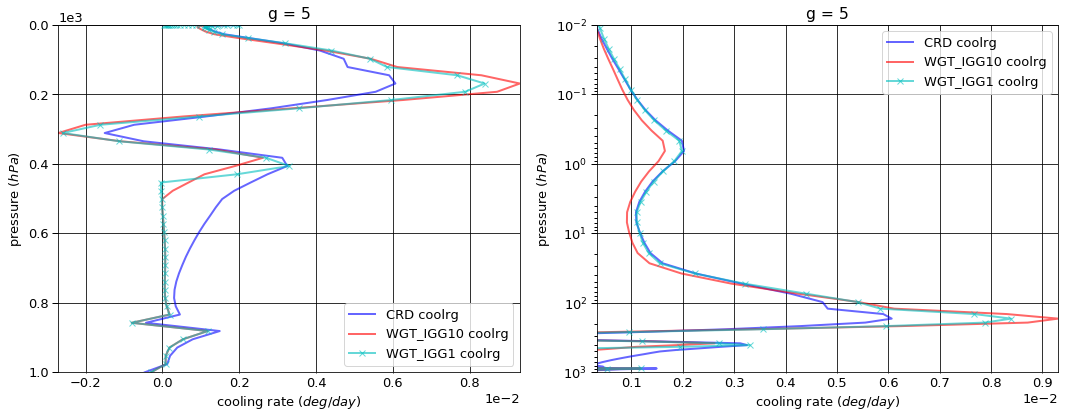

# Figure: cooling rate g-group 6

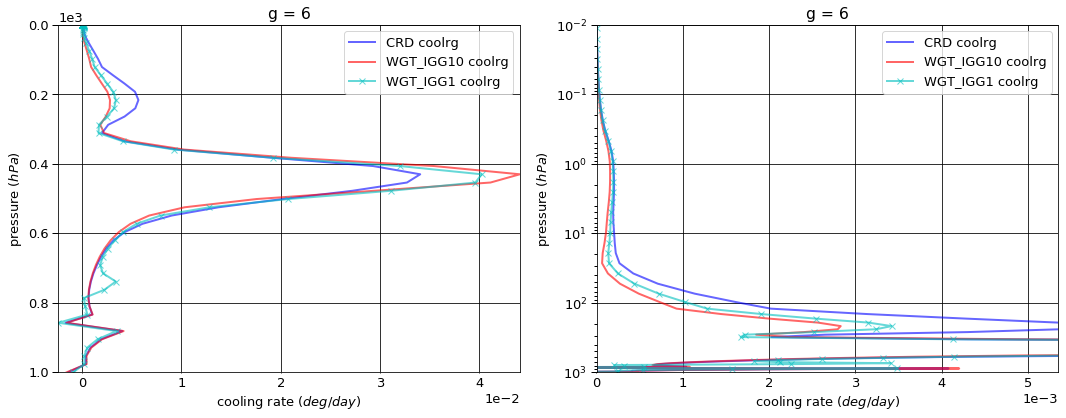

# Figure: cooling rate g-group 7

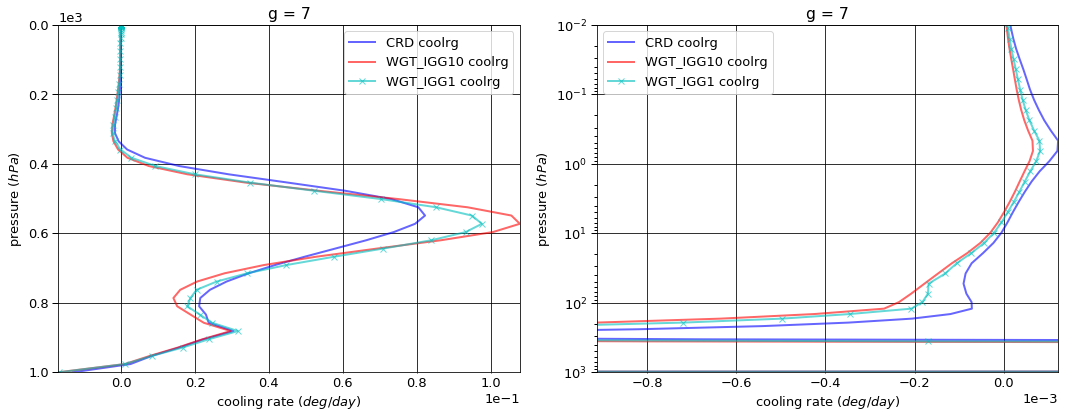

# Figure: cooling rate g-group 8

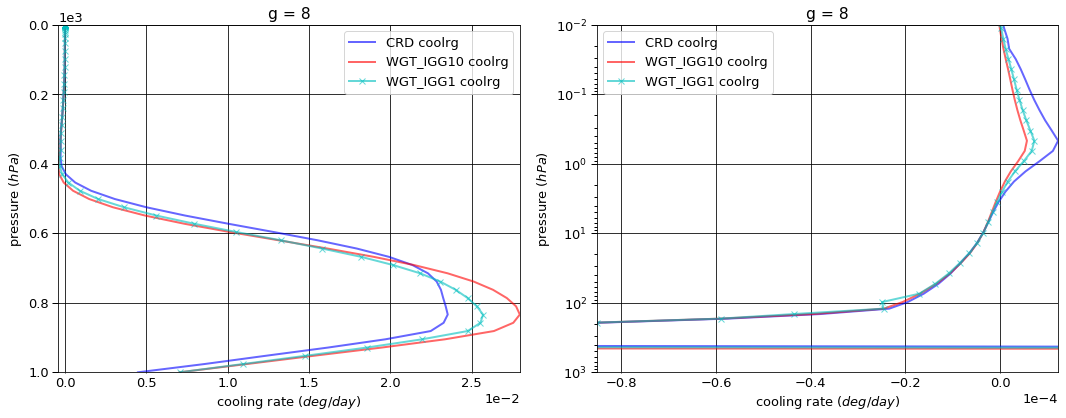

# Figure: cooling rate g-group total

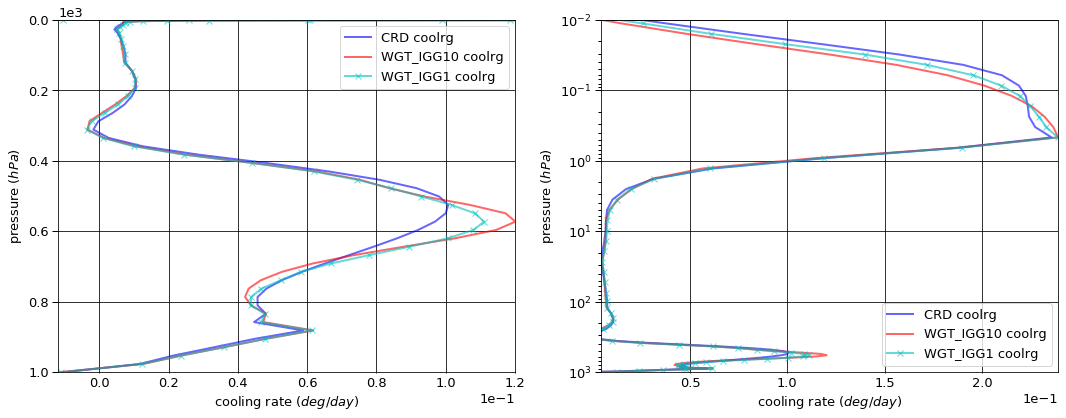

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009031  0.000000 -0.009031
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.013087  0.000000 -0.013087
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.015226  0.000000 -0.015226
  1013.0   76    -0.062332  0.062474  0.000142
4 0.0      1     -0.034230  0.000000 -0.034230
  1013.0   76    -0.183165  0.183410  0.000245
5 0.0      1     -0.195406  0.000000 -0.195406
  1013.0   76    -0.867888  0.869768  0.001880
6 0.0      1     -0.748353  0.000000 -0.748353
  1013.0   76    -2.563280  2.568040  0.004760
7 0.0      1     -2.737874  0.000000 -2.737874
  1013.0   76    -5.112614  5.186317  0.073703
8 0.0      1     -1.123652  0.000000 -1.123652
  1013.0   76    -1.354702  1.240871 -0.113832


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009614  0.000000 -0.009614
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.012945  0.000000 -0.012945
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.013327  0.000000 -0.013327
  1013.0   76    -0.062332  0.062404  0.000072
4 0.0      1     -0.032691  0.000000 -0.032691
  1013.0   76    -0.183165  0.183376  0.000210
5 0.0      1     -0.170894  0.000000 -0.170894
  1013.0   76    -0.867888  0.868885  0.000996
6 0.0      1     -0.751867  0.000000 -0.751867
  1013.0   76    -2.563280  2.568567  0.005287
7 0.0      1     -2.798969  0.000000 -2.798969
  1013.0   76    -5.112614  5.194290  0.081677
8 0.0      1     -1.161398  0.000000 -1.161398
  1013.0   76    -1.354702  1.269400 -0.085302


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009423  0.000000 -0.009423
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.012964  0.000000 -0.012964
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.013613  0.000000 -0.013613
  1013.0   76    -0.062332  0.062404  0.000072
4 0.0      1     -0.033011  0.000000 -0.033011
  1013.0   76    -0.183165  0.183376  0.000210
5 0.0      1     -0.170851  0.000000 -0.170851
  1013.0   76    -0.867888  0.868885  0.000996
6 0.0      1     -0.763433  0.000000 -0.763433
  1013.0   76    -2.563280  2.566229  0.002948
7 0.0      1     -2.818861  0.000000 -2.818861
  1013.0   76    -5.112614  5.201620  0.089006
8 0.0      1     -1.154370  0.000000 -1.154370
  1013.0   76    -1.354702  1.225343 -0.129359


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -5.830940e-04  0.000000e+00 -5.830940e-04
  1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
2 0.0      1      1.422290e-04  0.000000e+00  1.422290e-04
  1013.0   76     0.000000e+00 -2.120000e-07 -2.117960e-07
3 0.0      1      1.899444e-03  0.000000e+00  1.899444e-03
  1013.0   76     0.000000e+00 -7.066200e-05 -7.066224e-05
4 0.0      1      1.538257e-03  0.000000e+00  1.538257e-03
  1013.0   76     0.000000e+00 -3.439000e-05 -3.438614e-05
5 0.0      1      2.451144e-02  0.000000e+00  2.451144e-02
  1013.0   76     0.000000e+00 -8.836200e-04 -8.836277e-04
6 0.0      1     -3.513630e-03  0.000000e+00 -3.513630e-03
  1013.0   76     0.000000e+00  5.269000e-04  5.268240e-04
7 0.0      1     -6.109430e-02  0.000000e+00 -6.109430e-02
  1013.0   76    -8.881784e-16  7.973200e-03  7.973187e-03
8 0.0      1     -3.774600e-02  0.000000e+00 -3.774600e-02
  1013.0   76     0.000000e+00  2.852920e-02  2.852920e-02


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -3.919965e-04  0.000000e+00 -3.919965e-04
  1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
2 0.0      1      1.229640e-04  0.000000e+00  1.229640e-04
  1013.0   76     0.000000e+00 -2.120000e-07 -2.117960e-07
3 0.0      1      1.612926e-03  0.000000e+00  1.612926e-03
  1013.0   76     0.000000e+00 -7.066200e-05 -7.066224e-05
4 0.0      1      1.219196e-03  0.000000e+00  1.219196e-03
  1013.0   76     0.000000e+00 -3.439000e-05 -3.438614e-05
5 0.0      1      2.455434e-02  0.000000e+00  2.455434e-02
  1013.0   76     0.000000e+00 -8.836200e-04 -8.836277e-04
6 0.0      1     -1.508011e-02  0.000000e+00 -1.508011e-02
  1013.0   76     0.000000e+00 -1.811400e-03 -1.811454e-03
7 0.0      1     -8.098680e-02  0.000000e+00 -8.098680e-02
  1013.0   76    -8.881784e-16  1.530270e-02  1.530272e-02
8 0.0      1     -3.071880e-02  0.000000e+00 -3.071880e-02
  1013.0   76     0.000000e+00 -1.552750e-02 -1.552744e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.777749e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -2.253889e-02
  1001.112500 75    -8.831795e-06
3 0.000312    1     -4.650457e-05
  1001.112500 75    -3.777148e-05
4 0.000312    1      7.123054e-06
  1001.112500 75    -6.949578e-05
5 0.000312    1     -2.776314e-05
  1001.112500 75    -4.609310e-04
6 0.000312    1      1.662033e-07
  1001.112500 75    -1.382442e-03
7 0.000312    1     -4.791625e-06
  1001.112500 75    -1.304937e-02
8 0.000312    1     -2.013560e-06
  1001.112500 75     4.478762e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.542795e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -7.300867e-03
  1001.112500 75    -8.775581e-06
3 0.000312    1      2.642079e-04
  1001.112500 75    -2.108721e-05
4 0.000312    1      1.679122e-05
  1001.112500 75    -6.189075e-05
5 0.000312    1      4.149699e-05
  1001.112500 75    -2.930563e-04
6 0.000312    1      4.636498e-08
  1001.112500 75    -1.533918e-03
7 0.000312    1     -4.094732e-06
  1001.112500 75    -1.699222e-02
8 0.000312    1     -1.478396e-06
  1001.112500 75     7.031494e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.598105e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -1.811111e-02
  1001.112500 75    -8.775581e-06
3 0.000312    1      1.363866e-04
  1001.112500 75    -2.108721e-05
4 0.000312    1      1.890673e-05
  1001.112500 75    -6.189075e-05
5 0.000312    1      5.116336e-05
  1001.112500 75    -2.930563e-04
6 0.000312    1      2.130861e-07
  1001.112500 75    -8.671666e-04
7 0.000312    1     -3.812120e-06
  1001.112500 75    -1.687560e-02
8 0.000312    1     -1.527872e-06
  1001.112500 75     7.052808e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.349536e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.523802e-02
  1001.112500 75     5.621420e-08
3 0.000312    1      3.107125e-04
  1001.112500 75     1.668427e-05
4 0.000312    1      9.668171e-06
  1001.112500 75     7.605023e-06
5 0.000312    1      6.926013e-05
  1001.112500 75     1.678747e-04
6 0.000312    1     -1.198384e-07
  1001.112500 75    -1.514765e-04
7 0.000312    1      6.968931e-07
  1001.112500 75    -3.942848e-03
8 0.000312    1      5.351643e-07
  1001.112500 75     2.552731e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.796436e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      4.427785e-03
  1001.112500 75     5.621420e-08
3 0.000312    1      1.828912e-04
  1001.112500 75     1.668427e-05
4 0.000312    1      1.178368e-05
  1001.112500 75     7.605023e-06
5 0.000312    1      7.892650e-05
  1001.112500 75     1.678747e-04
6 0.000312    1      4.688282e-08
  1001.112500 75     5.152753e-04
7 0.000312    1      9.795050e-07
  1001.112500 75    -3.826228e-03
8 0.000312    1      4.856877e-07
  1001.112500 75     2.574045e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.876858,0.000000,-4.876858
1013.0,76,-10.181441,10.148383,-0.033058



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.951704,0.000000,-4.951704
1013.0,76,-10.181441,10.184423,0.002982



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.976527,0.000000,-4.976527
1013.0,76,-10.181441,10.145358,-0.036083



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.484565e-02,0.00000,-0.074846
1013.0,76,-1.776357e-15,0.03604,0.036040



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-9.966828e-02,0.000000,-0.099668
1013.0,76,-1.776357e-15,-0.003025,-0.003025


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.200388
1001.112500,75,-0.010534



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.161263
1001.112500,75,-0.011883



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.177720
1001.112500,75,-0.011079



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.039124
1001.112500,75,-0.001349



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.022667
1001.112500,75,-0.000545


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.017237,0.017975
5,0.081883,0.085181
6,0.244898,0.251475
7,0.483221,0.502779
8,0.163183,0.132796


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,1.255473e-20
5,8.096279e-22
6,2.585158e-21
7,1.675857e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009792,1.0
4,1.255473e-20,0.641708,0.017237,0.017975,0.026815,0.027768,10.0
5,8.096279e-22,0.064488,0.081883,0.085181,0.108698,0.112949,10.0
6,2.585158e-21,3.193020,0.244898,0.251475,0.353596,0.364424,500.0
7,1.675857e-22,0.064826,0.483221,0.502779,0.836817,0.867204,500.0
8,1.086393e-23,0.064826,0.163183,0.132796,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.660904e-17  8.716663e-18   1.905436  1.111989e-03
      2 0.000312     1.007676e-18  4.521776e-19   2.228496  6.452674e-05
      3 0.000312     2.776228e-20  1.170763e-20   2.371298  2.159183e-06
      4 0.000312     4.076190e-22  2.886772e-22   1.412024  3.319392e-08
      5 0.000312     2.671368e-22  7.208910e-23   3.705648  2.025810e-08
      6 0.000312     1.274070e-24  1.217364e-24   1.046581  1.036721e-10
      7 0.000312     2.718154e-24  1.331220e-24   2.041852  1.488021e-10
      8 0.000312     1.716542e-24  1.940221e-25   8.847147  8.783591e-11
2     1 0.000750     1.659848e-17  8.760099e-18   1.894782  4.483657e-04
      2 0.000750     1.021623e-18  4.586783e-19   2.227318  2.635397e-05
      3 0.000750     2.838684e-20  1.190019e-20   2.385410  8.888906e-07
      4 0.000750     4.177366e-22  2.966162e-22   1.408341  1.370591e-08
      5 0.000750     2.699106e-22  7.295245e-23   3.699815  8.245010e-09
      6 0.000750     1.311404e-24  1.253394e-24   1.046283  4.299365e-11
      7 0.000750     2.759508e-24  1.352569e-24   2.040197  6.087367e-11
      8 0.000750     1.730386e-24  1.965060e-25   8.805765  3.567865e-11
3     1 0.001052     1.657493e-17  8.845784e-18   1.873766  6.300134e-04
      2 0.001052     1.049976e-18  4.719099e-19   2.224949  3.799500e-05
      3 0.001052     2.967944e-20  1.227112e-20   2.418643  1.302097e-06
      4 0.001052     4.363947e-22  3.105718e-22   1.405133  2.008457e-08
      5 0.001052     2.756511e-22  7.453994e-23   3.698032  1.180886e-08
      6 0.001052     1.377473e-24  1.316669e-24   1.046181  6.333744e-11
      7 0.001052     2.845804e-24  1.395944e-24   2.038624  8.807429e-11
      8 0.001052     1.760180e-24  2.014780e-25   8.736335  5.093112e-11
4     1 0.001476     1.654770e-17  8.929689e-18   1.853110  8.853780e-04
      2 0.001476     1.078999e-18  4.855333e-19   2.222296  5.479385e-05
      3 0.001476     3.105824e-20  1.265278e-20   2.454657  1.909656e-06
      4 0.001476     4.570713e-22  3.259547e-22   1.402254  2.951827e-08
      5 0.001476     2.819318e-22  7.619975e-23   3.699904  1.694363e-08
      6 0.001476     1.451635e-24  1.387709e-24   1.046066  9.364977e-11
      7 0.001476     2.939547e-24  1.442295e-24   2.038104  1.276462e-10
      8 0.001476     1.793334e-24  2.066411e-25   8.678496  7.283822e-11
5     1 0.002070     1.651709e-17  9.010591e-18   1.833075  1.243672e-03
      2 0.002070     1.108320e-18  4.993793e-19   2.219396  7.896937e-05
      3 0.002070     3.251101e-20  1.304196e-20   2.492800  2.800868e-06
      4 0.002070     4.798716e-22  3.428587e-22   1.399619  4.347635e-08
      5 0.002070     2.887342e-22  7.792280e-23   3.705388  2.433667e-08
      6 0.002070     1.534761e-24  1.467364e-24   1.045931  1.388916e-10
      7 0.002070     3.040452e-24  1.491235e-24   2.038882  1.851428e-10
      8 0.002070     1.829877e-24  2.119402e-25   8.633929  1.042901e-10
6     1 0.002904     1.648314e-17  9.088367e-18   1.813652  1.746713e-03
      2 0.002904     1.137925e-18  5.134448e-19   2.216255  1.137756e-04
      3 0.002904     3.404185e-20  1.344018e-20   2.532841  4.109582e-06
      4 0.002904     5.052038e-22  3.615980e-22   1.397142  6.421809e-08
      5 0.002904     2.961167e-22  7.972447e-23   3.714251  3.500703e-08
      6 0.002904     1.628945e-24  1.557654e-24   1.045768  2.068166e-10
      7 0.002904     3.149396e-24  1.542927e-24   2.041183  2.688507e-10
      8 0.002904     1.870242e-24  2.173865e-25   8.603305  1.495647e-10
7     1 0.004074     1.644585e-17  9.162905e-18   1.794830  2.452671e-03
      2 0.004074     1.167798e-18  5.277289e-19   2.212876  1.638588e-04
      3 0.004074     3.565561e-20  1.385051e-20   2.574317  6.031758e-06
      4 0.004074     5.336062e-22  3.826066e-22   1.394660  9.516688e-08
      5 0.004074     3.041485e-22  8.162869e-23   3.726000  5.043168e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
